In [58]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
import warnings

from scipy.stats import zscore
from scipy.stats.mstats import winsorize

import matplotlib.pyplot as plt
%matplotlib inline

warnings.filterwarnings('ignore')
# Display up to 500 columns of a wide dataframe, instead of ...-ing them 
pd.set_option('display.max_columns', 500)

# Functions

In [62]:
# Pass in a dataframe, a list of columns to interpolate, and the limit direction.
# Loop through all of the columns and interpolate.
# Return the updated dataframe.
def interpolate_missing(df,key_column,column_list,limit_dir,**kwargs):
    interp_how = kwargs.get('interp_how','linear')
    for each_value in df[key_column].unique():
        for column in column_list:
            mask = (df[key_column] == each_value)
            df.loc[mask, column] = df.loc[mask, column].interpolate(limit_direction=limit_dir,method=interp_how)
    return df

In [63]:
def plot_naep(df,ranges,description):
    fig_hist = plt.figure(figsize=(15,15))
    fig_hist.suptitle('Average NAEP test scores, Minnesota: {}'.format(description),fontsize=14)
    plt.subplot(2,2,1)
    math4_hist = plt.hist(df['AVG_MATH_4_SCORE'],range=ranges[0])
    plt.title('4th grade Math')
    plt.subplot(2,2,2)
    math8 = plt.hist(df['AVG_MATH_8_SCORE'],range=ranges[1])
    plt.title('8th grade Math')
    plt.subplot(2,2,3)
    reading4 = plt.hist(df['AVG_READING_4_SCORE'],range=ranges[2])
    plt.title('4th grade Reading')
    plt.subplot(2,2,4)
    reading8 = plt.hist(df['AVG_READING_8_SCORE'],range=ranges[3])
    plt.title('8th grade Reading')
    plt.show()

# Assignment
In this assignment, you'll continue working with the U.S. Education Dataset from Kaggle. The data gives detailed state level information on the several facets of the state of education on an annual basis. To learn more about the data and the column descriptions, you can view the Kaggle link above. You should access the data from the Thinkful database. 

Don't forget to apply the most suitable missing value filling techniques you applied in the previous checkpoint to the data. You're supposed to provide your answers to the following questions after you handled the missing values.

In [64]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'useducation'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

# I connected via pgAdmin4 and verified the table name is the same as the db name
used_df = pd.read_sql_query('select * from useducation',con=engine)

# no need for an open connection, 
# as we're only doing a single query
engine.dispose()

In [65]:
# There are a lot of entries from US territories that are mostly NaNs and
# which don't have the full complement of data the states have--
# the only populated columns in most of these rows are for GRADES_*.
# These rows aren't particularly useful otherwise, so let's just drop them.
state_counts = used_df['STATE'].value_counts()

# A full complement of data for a state is 26 rows/years.
to_remove = state_counts[state_counts < 26].index

# Keep rows in the df where the state is not on the list to_remove
used_df = used_df[~used_df['STATE'].isin(to_remove)]

In [66]:
used_df = interpolate_missing(used_df,
                                     'STATE',
                                     ['ENROLL',
                                      'OTHER_EXPENDITURE',
                                      'GRADES_PK_G',
                                      'GRADES_KG_G',
                                      'GRADES_4_G',
                                      'GRADES_8_G',
                                      'GRADES_12_G',
                                      'GRADES_1_8_G',
                                      'GRADES_9_12_G',
                                      'GRADES_ALL_G'
                                     ],                                     
                                     'both')
# I interpolated these four variables in the cleaning assignment, but I see we have other plans for them here.
# I will leave them alone for now.

In [67]:
used_df.describe()

,YEAR,ENROLL,TOTAL_REVENUE,FEDERAL_REVENUE,STATE_REVENUE,LOCAL_REVENUE,TOTAL_EXPENDITURE,INSTRUCTION_EXPENDITURE,SUPPORT_SERVICES_EXPENDITURE,OTHER_EXPENDITURE,CAPITAL_OUTLAY_EXPENDITURE,GRADES_PK_G,GRADES_KG_G,GRADES_4_G,GRADES_8_G,GRADES_12_G,GRADES_1_8_G,GRADES_9_12_G,GRADES_ALL_G,AVG_MATH_4_SCORE,AVG_MATH_8_SCORE,AVG_READING_4_SCORE,AVG_READING_8_SCORE
count,1331.000000,1.331000e+03,1.280000e+03,1.280000e+03,1.280000e+03,1.280000e+03,1.280000e+03,1.280000e+03,1.280000e+03,1.331000e+03,1.280000e+03,1331.000000,1331.000000,1331.000000,1331.000000,1331.000000,1.331000e+03,1.331000e+03,1.331000e+03,536.000000,532.000000,533.000000,498.000000
mean,2004.515402,9.131361e+05,9.092082e+06,7.663723e+05,4.216553e+06,4.109157e+06,9.196681e+06,4.762966e+06,2.680331e+06,4.282389e+05,9.027693e+05,19350.306912,69781.791886,70629.268219,70297.409467,59976.570248,5.678150e+05,2.714961e+05,8.587217e+05,234.768293,278.414711,218.866154,263.661132
std,7.493076,1.062873e+06,1.174519e+07,1.145242e+06,5.543072e+06,5.482971e+06,1.197813e+07,6.293004e+06,3.353349e+06,5.366432e+05,1.327562e+06,30979.328421,82614.472330,82510.978461,80913.761323,70443.806263,6.600617e+05,3.167206e+05,1.000186e+06,10.221511,10.159722,7.769616,6.803725
min,1992.000000,4.386600e+04,4.656500e+05,3.102000e+04,0.000000e+00,2.209300e+04,4.816650e+05,2.655490e+05,1.399630e+05,1.154100e+04,1.270800e+04,0.000000,3459.000000,2548.000000,1485.000000,484.000000,1.922600e+04,2.758000e+03,2.455400e+04,187.134670,232.831510,178.557612,236.379102
25%,1998.000000,2.560480e+05,2.186305e+06,1.893540e+05,1.153097e+06,7.158345e+05,2.165404e+06,1.168032e+06,6.357900e+05,1.010325e+05,1.815645e+05,2621.500000,20032.000000,19814.000000,20214.000000,17074.000000,1.610640e+05,7.650500e+04,2.392380e+05,229.694352,272.761598,214.663401,259.533171
50%,2005.000000,6.483130e+05,5.079546e+06,4.033765e+05,2.537074e+06,2.055780e+06,5.234506e+06,2.657452e+06,1.525406e+06,2.689240e+05,5.102595e+05,9671.000000,48953.000000,49603.000000,49523.000000,39826.000000,4.012150e+05,1.822810e+05,6.056220e+05,237.238552,280.618803,220.416034,265.010912
75%,2011.000000,1.006874e+06,1.085985e+07,8.289660e+05,5.080939e+06,4.768680e+06,1.074519e+07,5.568028e+06,3.229651e+06,5.165750e+05,9.668515e+05,24675.500000,79396.000000,79198.000000,80513.500000,70997.000000,6.394140e+05,3.156855e+05,9.681460e+05,241.995486,285.347428,223.999337,268.190121
max,2017.000000,6.307022e+06,8.921726e+07,9.990221e+06,5.090457e+07,3.610526e+07,8.532013e+07,4.396452e+07,2.605802e+07,3.995951e+06,1.022366e+07,250911.000000,530531.000000,493415.000000,500143.000000,498403.000000,3.929869e+06,2.013687e+06,5.944746e+06,253.420961,300.568235,236.773867,280.499130


In [68]:
# The sum of null rows for each column * 100, divided by the total number of rows for each column:
used_df.isnull().sum()*100/used_df.isnull().count()

PRIMARY_KEY                      0.000000
STATE                            0.000000
YEAR                             0.000000
ENROLL                           0.000000
TOTAL_REVENUE                    3.831705
FEDERAL_REVENUE                  3.831705
STATE_REVENUE                    3.831705
LOCAL_REVENUE                    3.831705
TOTAL_EXPENDITURE                3.831705
INSTRUCTION_EXPENDITURE          3.831705
SUPPORT_SERVICES_EXPENDITURE     3.831705
OTHER_EXPENDITURE                0.000000
CAPITAL_OUTLAY_EXPENDITURE       3.831705
GRADES_PK_G                      0.000000
GRADES_KG_G                      0.000000
GRADES_4_G                       0.000000
GRADES_8_G                       0.000000
GRADES_12_G                      0.000000
GRADES_1_8_G                     0.000000
GRADES_9_12_G                    0.000000
GRADES_ALL_G                     0.000000
AVG_MATH_4_SCORE                59.729527
AVG_MATH_8_SCORE                60.030053
AVG_READING_4_SCORE             59

In [69]:
# Except for AVG scores, rows with a year == 2017 have all NaNs in other columns.
# We've interpolated the AVG columns and so have made use of the 2017 rows
# where those columns are populated, so let's drop 2017 now.
used_df = used_df[used_df['YEAR'] != 2017]

In [70]:
# The sum of null rows for each column * 100, divided by the total number of rows for each column:
used_df.isnull().sum()*100/used_df.isnull().count()

PRIMARY_KEY                      0.000000
STATE                            0.000000
YEAR                             0.000000
ENROLL                           0.000000
TOTAL_REVENUE                    0.000000
FEDERAL_REVENUE                  0.000000
STATE_REVENUE                    0.000000
LOCAL_REVENUE                    0.000000
TOTAL_EXPENDITURE                0.000000
INSTRUCTION_EXPENDITURE          0.000000
SUPPORT_SERVICES_EXPENDITURE     0.000000
OTHER_EXPENDITURE                0.000000
CAPITAL_OUTLAY_EXPENDITURE       0.000000
GRADES_PK_G                      0.000000
GRADES_KG_G                      0.000000
GRADES_4_G                       0.000000
GRADES_8_G                       0.000000
GRADES_12_G                      0.000000
GRADES_1_8_G                     0.000000
GRADES_9_12_G                    0.000000
GRADES_ALL_G                     0.000000
AVG_MATH_4_SCORE                62.109375
AVG_MATH_8_SCORE                62.421875
AVG_READING_4_SCORE             62

In [71]:
used_df['TOTAL_DIFFERENCE'] = used_df['TOTAL_REVENUE'] - used_df['TOTAL_EXPENDITURE']

In [72]:
used_df['TOTAL_REVENUE'] = winsorize(used_df['TOTAL_REVENUE'],(0,0.1))
used_df['TOTAL_EXPENDITURE'] = winsorize(used_df['TOTAL_EXPENDITURE'],(0,0.1))

In [73]:
winsorize(used_df['TOTAL_DIFFERENCE'], (0.1, 0.1),inplace=True)

masked_array(data=[  25087.,   77103., -143501., ..., -487915., -174881.,
                    249996.],
             mask=False,
       fill_value=1e+20)

## 1.Derive the descriptive statistics of the data and discuss the points you find remarkable.

In [74]:
used_df.describe()

,YEAR,ENROLL,TOTAL_REVENUE,FEDERAL_REVENUE,STATE_REVENUE,LOCAL_REVENUE,TOTAL_EXPENDITURE,INSTRUCTION_EXPENDITURE,SUPPORT_SERVICES_EXPENDITURE,OTHER_EXPENDITURE,CAPITAL_OUTLAY_EXPENDITURE,GRADES_PK_G,GRADES_KG_G,GRADES_4_G,GRADES_8_G,GRADES_12_G,GRADES_1_8_G,GRADES_9_12_G,GRADES_ALL_G,AVG_MATH_4_SCORE,AVG_MATH_8_SCORE,AVG_READING_4_SCORE,AVG_READING_8_SCORE,TOTAL_DIFFERENCE
count,1280.000000,1.280000e+03,1.280000e+03,1.280000e+03,1.280000e+03,1.280000e+03,1.280000e+03,1.280000e+03,1.280000e+03,1.280000e+03,1.280000e+03,1280.000000,1280.000000,1280.000000,1280.000000,1280.000000,1.280000e+03,1.280000e+03,1.280000e+03,485.000000,481.000000,482.000000,447.000000,1280.000000
mean,2004.017969,9.116706e+05,7.497001e+06,7.663723e+05,4.216553e+06,4.109157e+06,7.552608e+06,4.762966e+06,2.680331e+06,4.222320e+05,9.027693e+05,19038.937500,69664.090234,70485.978906,70194.607422,59614.644141,5.668963e+05,2.706240e+05,8.565999e+05,234.301986,278.047397,218.630267,263.436257,-65660.782031
std,7.205711,1.060012e+06,6.632447e+06,1.145242e+06,5.543072e+06,5.482971e+06,6.696642e+06,6.293004e+06,3.353349e+06,5.278970e+05,1.327562e+06,30686.330588,82275.301785,82249.043359,80702.085178,69833.118559,6.585042e+05,3.152977e+05,9.968944e+05,10.503934,10.368596,7.916273,6.847079,211192.202949
min,1992.000000,4.386600e+04,4.656500e+05,3.102000e+04,0.000000e+00,2.209300e+04,4.816650e+05,2.655490e+05,1.399630e+05,1.154100e+04,1.270800e+04,0.000000,3459.000000,2548.000000,1485.000000,484.000000,1.922600e+04,2.758000e+03,2.455400e+04,187.134670,232.831510,178.557612,236.379102,-487915.000000
25%,1998.000000,2.533458e+05,2.186305e+06,1.893540e+05,1.153097e+06,7.158345e+05,2.165404e+06,1.168032e+06,6.357900e+05,9.902825e+04,1.815645e+05,2594.500000,19891.000000,19686.750000,20119.500000,17059.750000,1.590518e+05,7.626500e+04,2.357432e+05,228.692001,271.905561,214.390668,259.151446,-181685.750000
50%,2004.000000,6.472755e+05,5.079546e+06,4.033765e+05,2.537074e+06,2.055780e+06,5.234506e+06,2.657452e+06,1.525406e+06,2.658320e+05,5.102595e+05,9403.500000,48757.000000,49305.500000,49427.500000,39663.500000,4.001715e+05,1.817525e+05,6.050375e+05,236.796927,280.176518,220.220168,264.837185,-21484.000000
75%,2010.000000,1.006750e+06,1.085985e+07,8.289660e+05,5.080939e+06,4.768680e+06,1.074519e+07,5.568028e+06,3.229651e+06,5.102788e+05,9.668515e+05,24263.500000,79396.000000,79093.250000,80452.250000,70630.000000,6.385595e+05,3.127090e+05,9.669560e+05,242.009196,285.052230,223.855210,268.112504,51304.250000
max,2016.000000,6.307022e+06,2.162392e+07,9.990221e+06,5.090457e+07,3.610526e+07,2.189622e+07,4.396452e+07,2.605802e+07,3.995951e+06,1.022366e+07,250911.000000,530531.000000,493415.000000,500143.000000,498403.000000,3.929869e+06,2.013687e+06,5.944746e+06,253.420961,300.568235,236.773867,277.191363,249996.000000


I noticed in the last exercise that the mean of that TOTAL_DIFFERENCE variable we created is a negative number, meaning on average (in the 26 years available here, at least), states have taken in less money for education than they have spent. Thankfully that mean is not large (only -$65,660) but even the winsorized maximum approaches a half million dollars.

Just noticed that the District of Columbia receives no state revenue (it makes sense, not being a state). It seems to run almost entirely on local revenue, with only a tiny amount of federal revenue.

In [75]:
used_df.loc[used_df['STATE_REVENUE'] == 0]

,PRIMARY_KEY,STATE,YEAR,ENROLL,TOTAL_REVENUE,FEDERAL_REVENUE,STATE_REVENUE,LOCAL_REVENUE,TOTAL_EXPENDITURE,INSTRUCTION_EXPENDITURE,SUPPORT_SERVICES_EXPENDITURE,OTHER_EXPENDITURE,CAPITAL_OUTLAY_EXPENDITURE,GRADES_PK_G,GRADES_KG_G,GRADES_4_G,GRADES_8_G,GRADES_12_G,GRADES_1_8_G,GRADES_9_12_G,GRADES_ALL_G,AVG_MATH_4_SCORE,AVG_MATH_8_SCORE,AVG_READING_4_SCORE,AVG_READING_8_SCORE,TOTAL_DIFFERENCE
8,1992_DISTRICT_OF_COLUMBIA,DISTRICT_OF_COLUMBIA,1992,80937.0,709480.0,64749.0,0.0,644731.0,742893.0,329160.0,316679.0,39819.0,47272.0,4818.0,6667.0,5832.0,5000.0,3433.0,47009.0,18173.0,70000.0,192.600553,234.924621,178.557612,265.976765,-33413.0
60,1993_DISTRICT_OF_COLUMBIA,DISTRICT_OF_COLUMBIA,1993,80937.0,721151.0,73882.0,0.0,647269.0,719440.0,339266.0,302281.0,39819.0,38074.0,5216.0,6986.0,5870.0,4935.0,3303.0,46917.0,17854.0,69987.0,NaN,NaN,NaN,NaN,1711.0
113,1994_DISTRICT_OF_COLUMBIA,DISTRICT_OF_COLUMBIA,1994,80678.0,735720.0,79432.0,0.0,656288.0,769818.0,351028.0,332951.0,63271.0,22568.0,5508.0,7628.0,5783.0,5031.0,3203.0,46557.0,16950.0,69015.0,NaN,NaN,NaN,NaN,-34098.0
165,1995_DISTRICT_OF_COLUMBIA,DISTRICT_OF_COLUMBIA,1995,80450.0,700111.0,65527.0,0.0,634584.0,708224.0,336543.0,301371.0,38207.0,32103.0,5387.0,7736.0,5852.0,4749.0,2972.0,46492.0,16727.0,68606.0,NaN,NaN,NaN,NaN,-8113.0
217,1996_DISTRICT_OF_COLUMBIA,DISTRICT_OF_COLUMBIA,1996,79802.0,678874.0,57870.0,0.0,621004.0,703245.0,334893.0,312944.0,39956.0,15452.0,5044.0,7469.0,5442.0,4625.0,3042.0,46313.0,16241.0,67598.0,187.134670,232.831510,181.626990,264.938466,-24371.0
268,1997_DISTRICT_OF_COLUMBIA,DISTRICT_OF_COLUMBIA,1997,78648.0,711625.0,73177.0,0.0,638448.0,686059.0,337401.0,272058.0,23494.0,53106.0,5156.0,6982.0,5357.0,4376.0,2961.0,45470.0,15896.0,66522.0,NaN,NaN,NaN,NaN,25566.0
320,1998_DISTRICT_OF_COLUMBIA,DISTRICT_OF_COLUMBIA,1998,77111.0,706938.0,116366.0,0.0,590572.0,716740.0,283484.0,339972.0,33393.0,59891.0,4831.0,6446.0,5607.0,4083.0,2572.0,42997.0,13932.0,61760.0,NaN,NaN,NaN,NaN,-9802.0
371,1999_DISTRICT_OF_COLUMBIA,DISTRICT_OF_COLUMBIA,1999,71889.0,758072.0,122970.0,0.0,635102.0,738942.0,314138.0,351290.0,29741.0,43773.0,4774.0,6617.0,6070.0,4408.0,2897.0,45931.0,15849.0,66554.0,NaN,NaN,NaN,NaN,19130.0
424,2000_DISTRICT_OF_COLUMBIA,DISTRICT_OF_COLUMBIA,2000,70762.0,881423.0,184825.0,0.0,696598.0,858807.0,318260.0,429891.0,23107.0,87549.0,4289.0,5357.0,5830.0,3371.0,2785.0,41330.0,13781.0,59400.0,193.289774,234.428798,190.518073,252.501705,22616.0
476,2001_DISTRICT_OF_COLUMBIA,DISTRICT_OF_COLUMBIA,2001,68925.0,1042261.0,114876.0,0.0,927385.0,1026146.0,412276.0,394656.0,35108.0,184106.0,4105.0,5203.0,5561.0,3662.0,2815.0,41292.0,13530.0,58927.0,NaN,NaN,NaN,NaN,16115.0


Wyoming apparently did not have students in Pre-K programs until 2000. The 2000 number also appears to be twice the number of subsequent years, and 2001 is not populated, which makes me wonder if 2000 and 2001 were counted together.

In [76]:
used_df.loc[used_df['GRADES_PK_G'] == 0].sort_values(['STATE','YEAR'])

,PRIMARY_KEY,STATE,YEAR,ENROLL,TOTAL_REVENUE,FEDERAL_REVENUE,STATE_REVENUE,LOCAL_REVENUE,TOTAL_EXPENDITURE,INSTRUCTION_EXPENDITURE,SUPPORT_SERVICES_EXPENDITURE,OTHER_EXPENDITURE,CAPITAL_OUTLAY_EXPENDITURE,GRADES_PK_G,GRADES_KG_G,GRADES_4_G,GRADES_8_G,GRADES_12_G,GRADES_1_8_G,GRADES_9_12_G,GRADES_ALL_G,AVG_MATH_4_SCORE,AVG_MATH_8_SCORE,AVG_READING_4_SCORE,AVG_READING_8_SCORE,TOTAL_DIFFERENCE
51,1992_WYOMING,WYOMING,1992,95012.0,629748.0,31714.0,314216.0,283818.0,624941.0,339953.0,185930.0,22980.0,60815.0,0.0,7184.0,8049.0,8078.0,6613.0,64614.0,28515.0,88832.0,225.377592,275.080076,221.185556,NaN,4807.0
103,1993_WYOMING,WYOMING,1993,100313.0,615130.0,35437.0,308683.0,271010.0,614807.0,334071.0,193624.0,21047.0,48076.0,0.0,7190.0,8046.0,8268.0,6548.0,64212.0,29497.0,88832.0,NaN,NaN,NaN,NaN,323.0
156,1994_WYOMING,WYOMING,1994,100899.0,674921.0,38849.0,351472.0,284600.0,623146.0,344562.0,192234.0,21161.0,48647.0,0.0,6929.0,7982.0,8203.0,6642.0,63201.0,30184.0,88832.0,NaN,NaN,NaN,NaN,51775.0
208,1995_WYOMING,WYOMING,1995,100314.0,634237.0,42456.0,303913.0,287868.0,642935.0,357039.0,198669.0,21975.0,48915.0,0.0,7135.0,7577.0,8302.0,6679.0,61796.0,30928.0,88832.0,NaN,NaN,NaN,NaN,-8698.0
259,1996_WYOMING,WYOMING,1996,99859.0,664057.0,41007.0,339629.0,283421.0,676305.0,360100.0,200228.0,21910.0,78444.0,0.0,6782.0,7283.0,8270.0,7129.0,60539.0,31722.0,88832.0,223.196003,274.778947,219.010780,254.523637,-12248.0
311,1997_WYOMING,WYOMING,1997,98777.0,660079.0,43171.0,320566.0,296342.0,695127.0,362705.0,206739.0,23104.0,84230.0,0.0,6496.0,7061.0,8232.0,7077.0,58894.0,31388.0,88832.0,NaN,NaN,NaN,NaN,-35048.0
362,1998_WYOMING,WYOMING,1998,96504.0,703280.0,47201.0,330204.0,325875.0,706801.0,366104.0,216102.0,22636.0,84596.0,0.0,6383.0,6873.0,7942.0,7057.0,57540.0,31292.0,88832.0,NaN,NaN,NaN,NaN,-3521.0
415,1999_WYOMING,WYOMING,1999,94420.0,780875.0,57983.0,408271.0,314621.0,739019.0,390565.0,237461.0,24829.0,71423.0,0.0,6133.0,6878.0,7715.0,7049.0,55493.0,30436.0,85929.0,NaN,NaN,NaN,NaN,41856.0
36,2001_WYOMING,WYOMING,2001,89711.0,804297.0,69172.0,403021.0,332104.0,787949.0,426072.0,254937.0,24913.0,67913.0,0.0,6002.0,6587.0,7211.0,6855.0,53091.0,29035.0,88832.0,NaN,NaN,NaN,NaN,16348.0


## 2. Choose a state (e.g. California) and draw a line graph of its total revenues and total expenditures along the years. How do these 2 variables evolve during the years? Try to explain the peaks and troughs with some state-wise news and information around those dates.

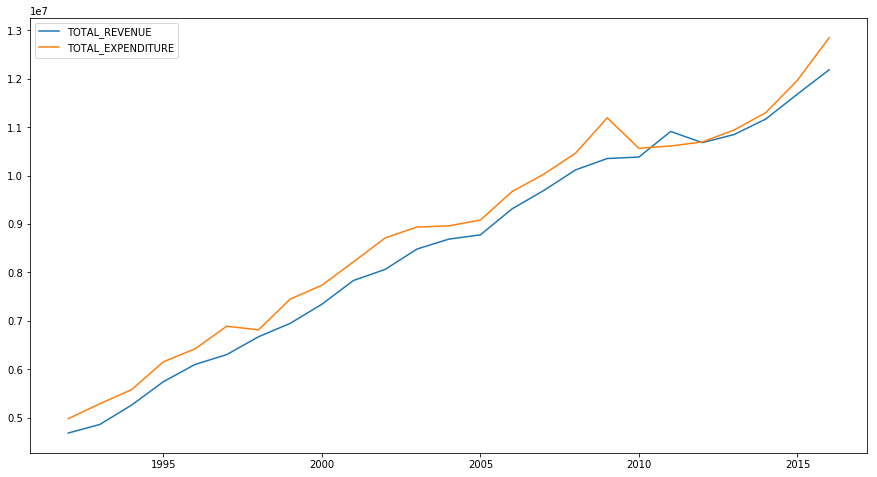

In [77]:
plt.figure(figsize=(15,8))
plot_me = used_df.loc[used_df['STATE'] == 'MINNESOTA'][['YEAR','TOTAL_REVENUE','TOTAL_EXPENDITURE']]
plt.plot(plot_me['YEAR'],plot_me[['TOTAL_REVENUE','TOTAL_EXPENDITURE']])
plt.legend(plot_me[['TOTAL_REVENUE','TOTAL_EXPENDITURE']])

[This Minnpost article](https://www.minnpost.com/education/2018/05/minnesota-debates-last-minute-funding-boost-some-historical-context-state-funding/) suggests "A bump in spending in 2009 appears to be largely due to an increase in employee benefits."

The bump in revenue around 2010-2011 is likely federal stimulus money passed in 2009, discussed in [this MPR article](https://www.mprnews.org/story/2010/02/16/stimulus-oneyear) and [on the US Department of Education's website](https://www2.ed.gov/policy/gen/leg/recovery/implementation.html).

[This Pioneer Press article](https://www.twincities.com/2017/06/17/new-money-from-capitol-but-minnesota-schools-still-cant-meet-their-budgets/) discusses how school budgets are not keeping pace with inflation and spending needs, which helps explain how expenditures rise faster than revenue after the 2010-2011 bump. There is also a mention of programs for students with special needs and how they are consuming increasing amounts of resources as schools try to invest more in accommodating everyone.

## 3. In your chosen state, which of the lessons are the students more successful, math or reading?

Reminder, from the earlier lesson: I found some information about interpreting NAEP scores [here](https://nces.ed.gov/nationsreportcard/mathematics/interpret_results.aspx). These values are continuous, interval--there is a "zero" within the possible range of values, but the ranges are not the same between grades, and it's not clear that an average score of, say, 300 means those students know exactly twice as much about reading or math as a group of students with an average of 150.

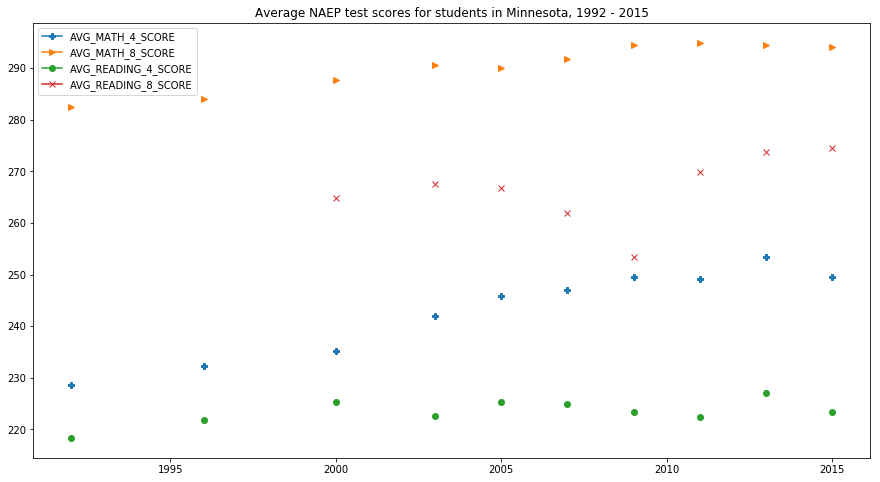

In [78]:
fig = plt.figure(figsize=(15,8))

plot_me = used_df.loc[used_df['STATE'] == 'MINNESOTA'][['STATE','YEAR',
                                                        'AVG_MATH_4_SCORE',
                                                        'AVG_MATH_8_SCORE',
                                                        'AVG_READING_4_SCORE',
                                                        'AVG_READING_8_SCORE'
                                                       ]]
math4 = plt.plot(plot_me['YEAR'],plot_me[['AVG_MATH_4_SCORE']],marker='P')
math8 = plt.plot(plot_me['YEAR'],plot_me[['AVG_MATH_8_SCORE']],marker='>')
reading4 = plt.plot(plot_me['YEAR'],plot_me[['AVG_READING_4_SCORE']],marker='o')
reading8 = plt.plot(plot_me['YEAR'],plot_me[['AVG_READING_8_SCORE']],marker='x')

legend = plt.legend(plot_me[['AVG_MATH_4_SCORE',
                    'AVG_MATH_8_SCORE',
                    'AVG_READING_4_SCORE',
                    'AVG_READING_8_SCORE'
                     ]])

title = plt.title('Average NAEP test scores for students in Minnesota, 1992 - 2015')

Both 4th graders and 8th graders are stronger in math than in reading according to these NAEP test results.

## 4. What are the distributions of the math and reading scores in the sample?

In [79]:
plot_me.describe()

,YEAR,AVG_MATH_4_SCORE,AVG_MATH_8_SCORE,AVG_READING_4_SCORE,AVG_READING_8_SCORE
count,25.000000,10.000000,10.000000,10.000000,8.000000
mean,2004.000000,243.225285,290.482975,223.417188,266.586378
std,7.359801,8.452158,4.507755,2.416406,6.827912
min,1992.000000,228.493596,282.392205,218.301709,253.329004
25%,1998.000000,236.931240,288.257706,222.383745,264.157579
50%,2004.000000,246.371977,291.265586,223.344791,267.168032
75%,2010.000000,249.388322,294.369435,225.149185,270.854786
max,2016.000000,253.420961,294.946423,227.030742,274.497568


I can use the min/max of each variable to set the ranges of their respective histograms. This way it should be easier to see the distribution of each average score.

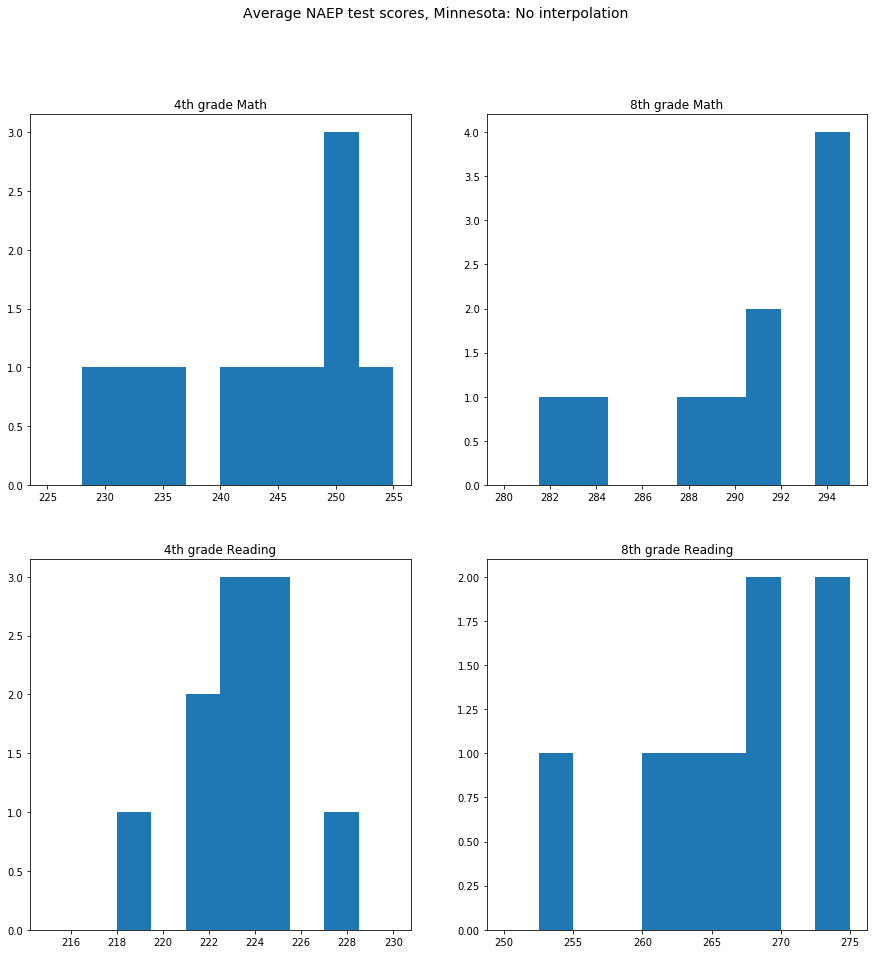

In [80]:
test_ranges = [(225,255),(280,295),(215,230),(250,275)]
plot_naep(plot_me,test_ranges,"No interpolation")

The 4th grade Reading distribution appears almost normal...? The other three are left skewed. There are so few samples for each, it's hard to get a good idea. 

In [81]:
used_df_mean = plot_me

In [82]:
plot_me

,STATE,YEAR,AVG_MATH_4_SCORE,AVG_MATH_8_SCORE,AVG_READING_4_SCORE,AVG_READING_8_SCORE
23,MINNESOTA,1992,228.493596,282.392205,218.301709,NaN
76,MINNESOTA,1993,NaN,NaN,NaN,NaN
128,MINNESOTA,1994,NaN,NaN,NaN,NaN
180,MINNESOTA,1995,NaN,NaN,NaN,NaN
232,MINNESOTA,1996,232.193088,284.048945,221.830114,NaN
283,MINNESOTA,1997,NaN,NaN,NaN,NaN
335,MINNESOTA,1998,NaN,NaN,NaN,NaN
387,MINNESOTA,1999,NaN,NaN,NaN,NaN
439,MINNESOTA,2000,235.270888,287.651942,225.258514,264.888121
492,MINNESOTA,2001,NaN,NaN,NaN,NaN


## 5. Notice there are too many missing values for math and reading scores. Fill out the missing values using mean, median, and linear interpolation. Then compare the effects of these techniques on the distributions of the score variables.


### Filling in missing values w/mean

In [95]:
used_df_mean = plot_me.fillna(plot_me.mean())

In [96]:
used_df_mean

,STATE,YEAR,AVG_MATH_4_SCORE,AVG_MATH_8_SCORE,AVG_READING_4_SCORE,AVG_READING_8_SCORE
23,MINNESOTA,1992,228.493596,282.392205,218.301709,266.586378
76,MINNESOTA,1993,243.225285,290.482975,223.417188,266.586378
128,MINNESOTA,1994,243.225285,290.482975,223.417188,266.586378
180,MINNESOTA,1995,243.225285,290.482975,223.417188,266.586378
232,MINNESOTA,1996,232.193088,284.048945,221.830114,266.586378
283,MINNESOTA,1997,243.225285,290.482975,223.417188,266.586378
335,MINNESOTA,1998,243.225285,290.482975,223.417188,266.586378
387,MINNESOTA,1999,243.225285,290.482975,223.417188,266.586378
439,MINNESOTA,2000,235.270888,287.651942,225.258514,264.888121
492,MINNESOTA,2001,243.225285,290.482975,223.417188,266.586378


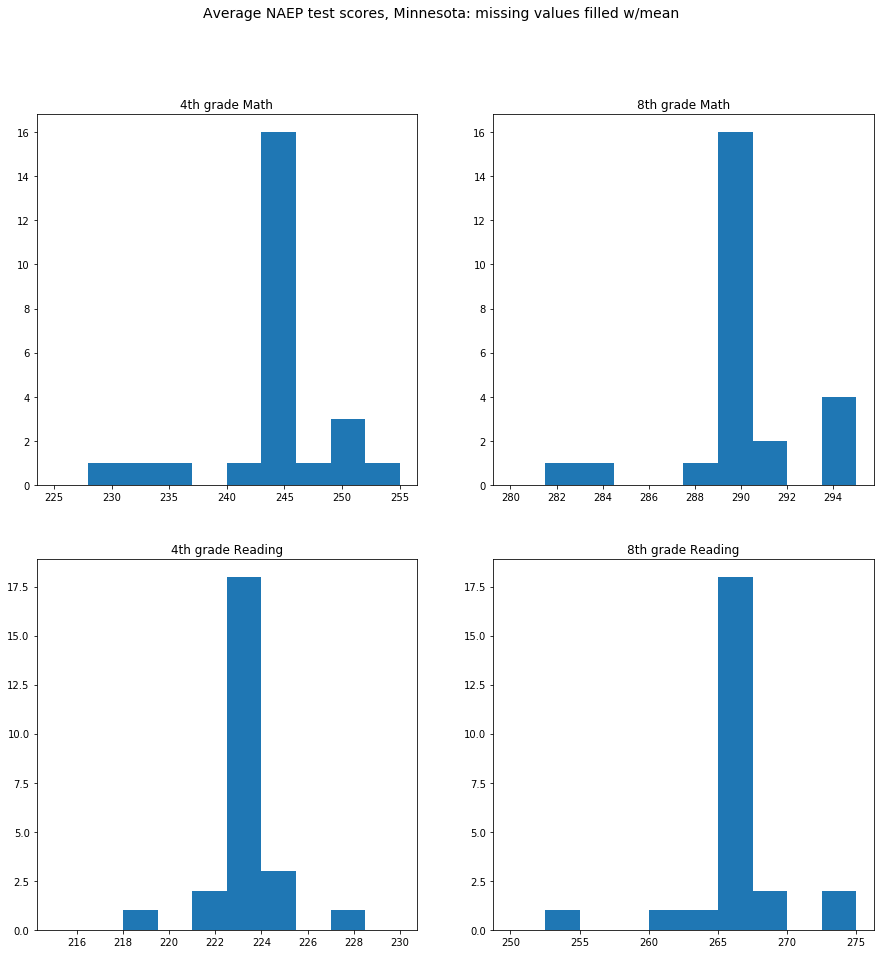

In [97]:
plot_naep(used_df_mean,test_ranges,"missing values filled w/mean")

Histograms of the data generated by applying this technique _really_ emphasize the mean.

### Filling in missing values w/median

In [93]:
used_df_median = plot_me.fillna(plot_me.median())

In [94]:
used_df_median

,STATE,YEAR,AVG_MATH_4_SCORE,AVG_MATH_8_SCORE,AVG_READING_4_SCORE,AVG_READING_8_SCORE
23,MINNESOTA,1992,228.493596,282.392205,218.301709,267.168032
76,MINNESOTA,1993,246.371977,291.265586,223.344791,267.168032
128,MINNESOTA,1994,246.371977,291.265586,223.344791,267.168032
180,MINNESOTA,1995,246.371977,291.265586,223.344791,267.168032
232,MINNESOTA,1996,232.193088,284.048945,221.830114,267.168032
283,MINNESOTA,1997,246.371977,291.265586,223.344791,267.168032
335,MINNESOTA,1998,246.371977,291.265586,223.344791,267.168032
387,MINNESOTA,1999,246.371977,291.265586,223.344791,267.168032
439,MINNESOTA,2000,235.270888,287.651942,225.258514,264.888121
492,MINNESOTA,2001,246.371977,291.265586,223.344791,267.168032


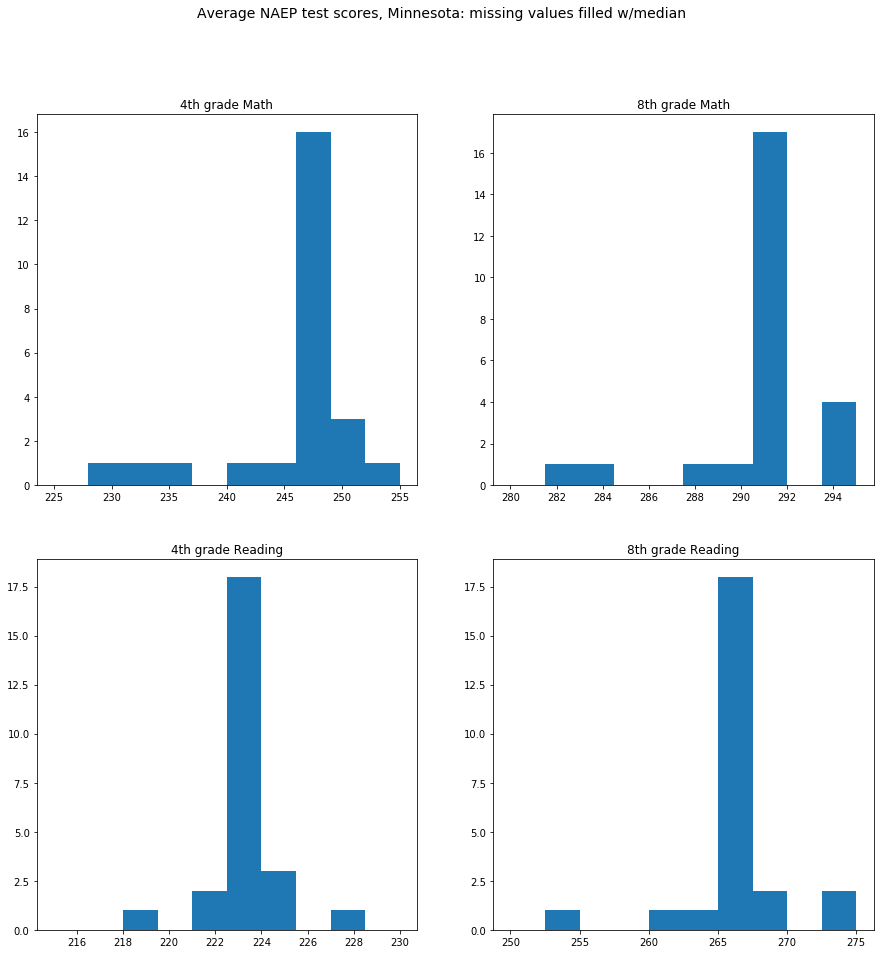

In [99]:
plot_naep(used_df_median,test_ranges,"missing values filled w/median")

The means and medians for these variables were relatively close in all cases, so it's not a surprise to see the graphs look the same.

### Filling in missing values w/linear interpolation

In [53]:
used_df_interp = interpolate_missing(plot_me,
                                     'STATE',
                                     ['AVG_MATH_4_SCORE',
                                      'AVG_MATH_8_SCORE',
                                      'AVG_READING_4_SCORE',
                                      'AVG_READING_8_SCORE'
                                     ],
                                     'both',interp_how='linear')

In [54]:
used_df_interp

,STATE,YEAR,AVG_MATH_4_SCORE,AVG_MATH_8_SCORE,AVG_READING_4_SCORE,AVG_READING_8_SCORE
23,MINNESOTA,1992,228.493596,282.392205,218.301709,264.888121
76,MINNESOTA,1993,229.418469,282.806390,219.183810,264.888121
128,MINNESOTA,1994,230.343342,283.220575,220.065912,264.888121
180,MINNESOTA,1995,231.268215,283.634760,220.948013,264.888121
232,MINNESOTA,1996,232.193088,284.048945,221.830114,264.888121
283,MINNESOTA,1997,232.962538,284.949694,222.687214,264.888121
335,MINNESOTA,1998,233.731988,285.850443,223.544314,264.888121
387,MINNESOTA,1999,234.501438,286.751193,224.401414,264.888121
439,MINNESOTA,2000,235.270888,287.651942,225.258514,264.888121
492,MINNESOTA,2001,237.484690,288.661313,224.375330,265.760358


Note that there was no value for AVG_READING_8_SCORE before 2000, so the 2000 value is carried backward each year to 1992 w/no change. It causes a big bump on the right edge of its associated graph below (top right).

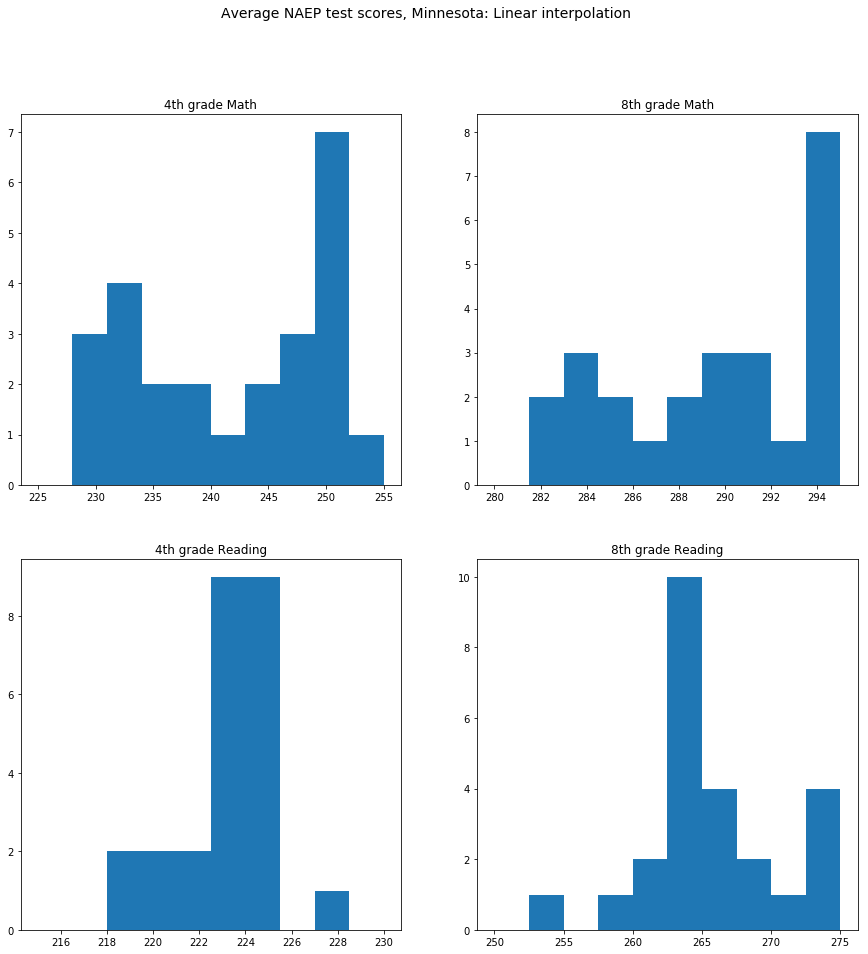

In [50]:
plot_naep(used_df_interp,test_ranges,"Linear interpolation")

Linear interpolation made somewhat nicer-looking graphs that appear to have more or less the same distribution as graphs of the unaltered data. The exception is the 8th grade Math score averages, where the additional missing values before 2000 were all filled in with a single value when linear interpolation was applied.